<a href="https://colab.research.google.com/github/vivekkchandra/CE888/blob/master/Exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab 8. Transfer Learning**
##**Exercise 1. Using a Pre-Trained Model for Feature Extraction**

**Preparing the coding environment and getting the pre-trained model and data files into the file system.**

In [0]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

     |████████████████████████████████| 43.6MB 75kB/s 
     |████████████████████████████████| 1.6MB 35.5MB/s 
     |████████████████████████████████| 890kB 38.4MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=2deb9f4a343671a0d4a09bbe12e64934daeb4ce7b5e994d21448dc4b8d282c93
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.3
    Uninstalling bleach-3.1.3:
      Successfully uninstalled bleach-3.1.3
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1
     |████████████████████████████████| 276kB 2.6MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.7 which is incompat

In [0]:
!git clone https://github.com/sagihaider/CE888_2020.git

Cloning into 'CE888_2020'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 25162 (delta 36), reused 4 (delta 0), pack-reused 25082
Receiving objects: 100% (25162/25162), 562.19 MiB | 48.43 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [0]:
import numpy as np
import os
import time
from CE888_2020.Lab_8.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarn

In [0]:
# Upload data
from zipfile import ZipFile
file_name = "/content/CE888_2020/Lab_8/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [0]:
os.environ['KAGGLE_USERNAME'] = "vejeypradeep" # username from the json file
os.environ['KAGGLE_KEY'] = "befb8df93fe4103b8d142d23986bc764" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle

 95% 257M/271M [00:02<00:00, 133MB/s]
100% 271M/271M [00:02<00:00, 125MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 98.2MB/s]
 97% 527M/543M [00:02<00:00, 190MB/s]
100% 543M/543M [00:03<00:00, 182MB/s]


In [0]:
file_name = "/content/train.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


**Creating specific directories for training, evaluation and testing. Moving the corresponding data to these directories.**

In [0]:
original_dataset_dir = '/content/train'
base_dir = '/content/cats_and_dogs'

In [0]:
os.mkdir(base_dir)

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [0]:
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)
os.mkdir(train_cats_dir)
os.mkdir(train_dogs_dir)
os.mkdir(validation_cats_dir)
os.mkdir(validation_dogs_dir)
os.mkdir(test_cats_dir)
os.mkdir(test_dogs_dir)

In [0]:
import shutil
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir))) 

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


**Pre-processing the images from each of the created directories and storing them in numpy arrays (in-memory).**

In [0]:
train_dir_list = os.listdir(train_dir)
validation_dir_list = os.listdir(validation_dir)
test_dir_list = os.listdir(test_dir)

In [0]:
def create_image_list(data_dir_list, data_dir):
  img_data_list = []
  for dataset in data_dir_list:
    img_list = os.listdir(data_dir + '/' + dataset)
    print ('Loading the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
      img_path = data_dir + '/'+ dataset + '/'+ img
      img = image.load_img(img_path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      img_data_list.append(x)
  return img_data_list

In [0]:
train_images = np.array(create_image_list(train_dir_list, train_dir))
print(train_images.shape)
train_images = np.rollaxis(train_images, 1, 0)
print (train_images.shape)
train_images = train_images[0]
print (train_images.shape)

Loading the images of dataset-dogs

Loading the images of dataset-cats

(2000, 1, 224, 224, 3)
(1, 2000, 224, 224, 3)
(2000, 224, 224, 3)


In [0]:
validation_images = np.array(create_image_list(validation_dir_list, validation_dir))
print(validation_images.shape)
validation_images = np.rollaxis(validation_images, 1, 0)
print (validation_images.shape)
validation_images = validation_images[0]
print (validation_images.shape)

Loading the images of dataset-dogs

Loading the images of dataset-cats

(1000, 1, 224, 224, 3)
(1, 1000, 224, 224, 3)
(1000, 224, 224, 3)


In [0]:
test_images = np.array(create_image_list(test_dir_list, test_dir))
print(test_images.shape)
test_images = np.rollaxis(test_images, 1, 0)
print (test_images.shape)
test_images = test_images[0]
print (test_images.shape)

Loading the images of dataset-dogs

Loading the images of dataset-cats

(1000, 1, 224, 224, 3)
(1, 1000, 224, 224, 3)
(1000, 224, 224, 3)


**Creating the corresponding classification labels for each numpy array.**

In [0]:
num_classes = 2
label_names = ['dogs', 'cats']

In [0]:
train_num_samples = train_images.shape[0]
train_labels = np.ones((train_num_samples,), dtype='int64')
train_labels[0 : int(train_num_samples / 2)] = 0
train_labels[int(train_num_samples / 2) :] = 1
train_labels = np_utils.to_categorical(train_labels, num_classes)

In [0]:
validation_num_samples = validation_images.shape[0]
validation_labels = np.ones((validation_num_samples,), dtype='int64')
validation_labels[0 : int(validation_num_samples / 2)] = 0
validation_labels[int(validation_num_samples / 2) :] = 1
validation_labels = np_utils.to_categorical(validation_labels, num_classes)

In [0]:
test_num_samples = test_images.shape[0]
test_labels = np.ones((test_num_samples,), dtype='int64')
test_labels[0 : int(test_num_samples / 2)] = 0
test_labels[int(test_num_samples / 2) :] = 1
test_labels = np_utils.to_categorical(test_labels, num_classes)

**Importing the model and replacing the last layer for achieving transfer learning.**

In [0]:
image_input = Input(shape=(224, 224, 3)) # shape of a single image
model = VGG16(input_tensor=image_input, include_top=True, weights='imagenet') # load VGG-16 model with 'top = true'
model.summary()

552869888/553467096 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (M

In [0]:
last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

custom_vgg_model.summary()
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Training the modified model.**

In [0]:
t = time.time()
hist = custom_vgg_model.fit(train_images, train_labels, batch_size=16, epochs=2, verbose=1, validation_data=(validation_images, validation_labels))
print('Training time: %s' % (time.time() - t))
(loss, accuracy) = custom_vgg_model.evaluate(test_images, test_labels, batch_size=10, verbose=1)

print()
print(f"Test results on {len(test_images)}")
print("loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

Train on 2000 samples, validate on 1000 samples
Epoch 1/2
2000/2000 [==============================] - 2429s - loss: 0.0864 - acc: 0.9695 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 2/2
2000/2000 [==============================] - 2460s - loss: 0.0335 - acc: 0.9860 - val_loss: 0.0617 - val_acc: 0.9790
Training time: 4890.6937084198
1000/1000 [==============================] - 826s   

Test results on 1000
loss=0.0778, accuracy: 98.0000%


**Plotting the train loss and accuracy against the validation loss and accuracy.**

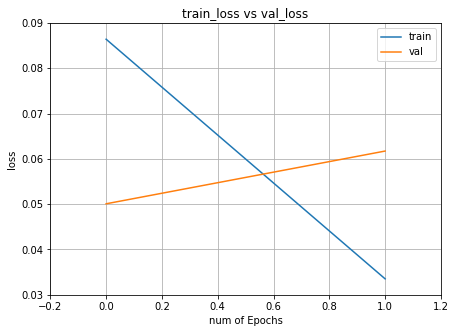

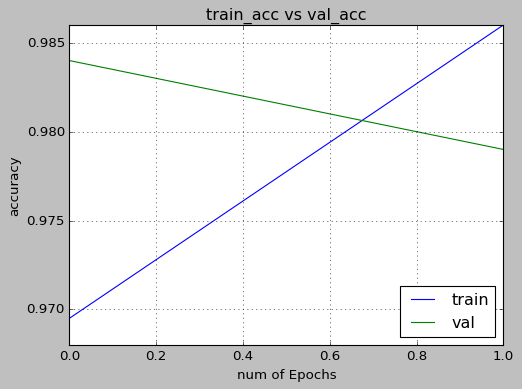

In [0]:
import matplotlib.pyplot as plt

# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(2)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])